In [35]:
import requests
import random as rd
import matplotlib.pyplot as plt
import numpy as np
from ortools.sat.python import cp_model


url = 'https://raw.githubusercontent.com/tamy0612/JSPLIB/master/instances.json'
response = requests.get(url)
pull = response.json()  # Parse the JSON

def instances_(i):
    if i > len(pull)-1:
        return print(f'Error: Please use a number less than {len(pull)}')
    else:
        url = f'https://raw.githubusercontent.com/tamy0612/JSPLIB/master/instances/{pull[i]["name"]}'
        response = requests.get(url)
        data = response.text # Parse the txt
        data = data.splitlines()[5:] # Dropping the first 5

        # Split each string into individual numbers and flatten the result
        flattened_data = [int(num) for line in data for num in line.split()]
        flattened_data = [(flattened_data[i], flattened_data[i+1]) for i in range(0, len(flattened_data)-1,2)]

        jobs = len(data)
        machines = int((len(flattened_data)/len(data)))

        # Convert to a 10x10x2 NumPy array
        instance = np.array(flattened_data).reshape(jobs, machines,2)
        instance = {i: {int(instance[i,j][0]): int(instance[i,j][1]) for j in range(machines)} for i in range(jobs)}
        return jobs, machines, instance

In [36]:
val = rd.randint(0,len(pull)-1)
jobs, machines, instance = instances_(0)
# jobs, machines, instance = instances_(val)

In [37]:
# Creates the model and set solver
model = cp_model.CpModel()
solver = cp_model.CpSolver()

horizon = sum(instance[i][j] for i in instance for j in instance[i])

obj = model.NewIntVar(0,horizon,'makespan')

x1 = {(i,j): model.NewIntVar(0,\
                         sum([instance[i][j] for i in instance for j in instance[i]]) - \
                            max([instance[i][j] for i in instance for j in instance[i]]),\
                                f'x1_{i}_{j}') for i in instance for j in instance[i]}

x2 = {(i,j): model.NewIntVar(max([instance[i][j] for i in instance for j in instance[i]]),\
                         sum([instance[i][j] for i in instance for j in instance[i]]), \
                            f'x2_{i}_{j}') for i in instance for j in instance[i]}

interval = {(i,j): model.NewIntervalVar(x1[i,j], instance[i][j], x2[i,j], f'interval_{i}_{j}') \
            for i in instance for j in instance[i]}

for j in range(machines):
   model.AddNoOverlap([interval[i,j] for i in instance])

for i in range(jobs):
   lst = list(instance[i].keys())
   for j in range(len(lst)):
      if j+1 < len(lst):
         model.Add(x2[i,lst[j]] <= x1[i,lst[j+1]])

model.AddMaxEquality(obj, [x2[i,j] for i in instance for j in instance[i]])

model.Minimize(obj)

status = solver.Solve(model)
print(f'Status = {solver.StatusName(status)}')

print(f'Makespan: {solver.value(obj)} minutes.')

Status = OPTIMAL
Makespan: 1238 minutes.


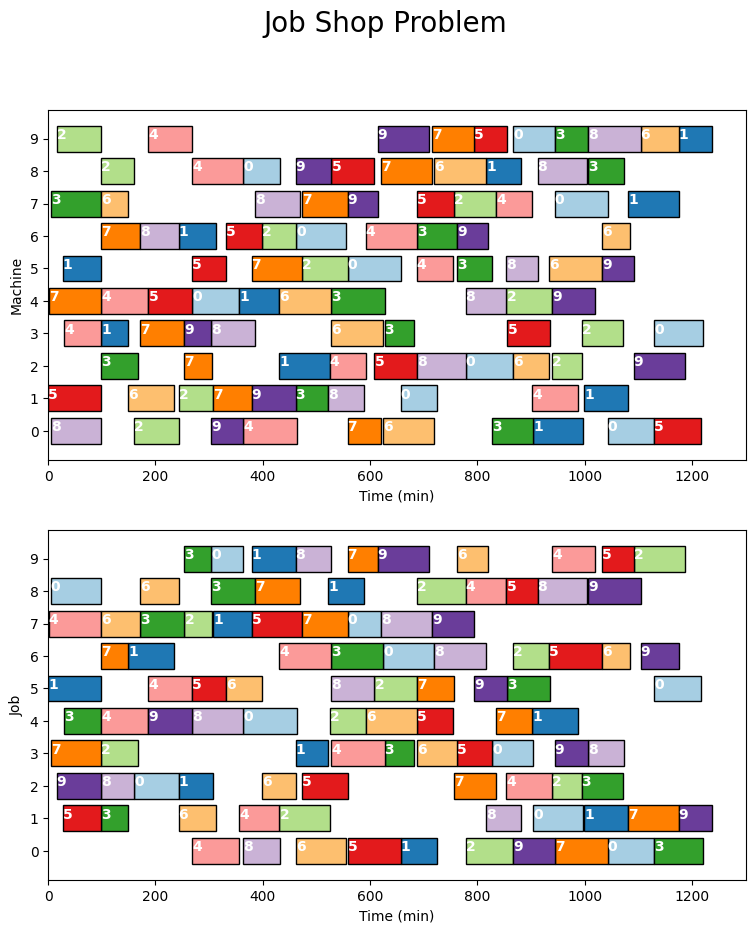

In [38]:
data = sorted([((i,j), (solver.value(x1[i,j]),solver.value(x2[i,j]))) \
               for i in instance for j in instance[i]], key = lambda k: [k[0][1], k[0][0]])
data2 = sorted(data, key= lambda k: [k[0][0]])

fig, ax = plt.subplots(2,1)
fig.suptitle('Job Shop Problem',fontsize = 20)

color = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

fig.set_figheight(max(jobs,machines))
fig.set_figwidth(max(jobs,machines)-1)

ax[0].barh(y = [str(data[i][0][1]) for i in range(len(data))], \
        left= [data[i][1][0] for i in range(len(data))], \
            width= [data[i][1][1] - data[i][1][0] for i in range(len(data))], color = color, edgecolor = 'k');

ax[1].barh(y = [str(data2[i][0][0]) for i in range(len(data2))], \
        left= [data2[i][1][0] for i in range(len(data2))], \
            width= [data2[i][1][1] - data2[i][1][0] for i in range(len(data2))], color = color, edgecolor = 'k');


for i in range(len(data)):
    ax[0].text(x=data[i][1][0], y=str(data[i][0][1]), s=str(data[i][0][0]), color = 'w', fontweight = 'bold')
    ax[1].text(x=data2[i][1][0], y=str(data2[i][0][0]), s=str(data2[i][0][1]), color = 'w', fontweight = 'bold')


ax[0].set_xlabel('Time (min)');
ax[0].set_ylabel('Machine');

ax[1].set_xlabel('Time (min)');
ax[1].set_ylabel('Job');